# Combining all currently available data sources to reach maximum number of deals with industry assigned

## First: load all scrapped companies

In [68]:
import pandas as pd
import numpy as np

found_companies = pd.read_csv('../data/companies-with-linkedin-data.csv', index_col=0)
found_companies.count()


Associated Company ID    612
Associated Company       612
Industry                 291
Deal Name                612
Deal Stage               612
LinkedIn description     600
LinkedIn size            584
LinkedIn specialties     427
LinkedIn established     495
LinkedIn id              612
LinkedIn url             612
LinkedIn Industry        596
dtype: int64

## Load unrecognized companies but select only ones with Industry

In [69]:
unrecognized_companies = pd.read_csv('../data/unrecognized-companies.csv', index_col=0)
unrecognized_companies = unrecognized_companies[~unrecognized_companies['Industry'].isnull()]
unrecognized_companies.count()

Associated Company ID    62
Associated Company       62
Industry                 62
Deal Name                62
Deal Stage               62
dtype: int64

## Second: concat those companies

In [70]:
companies = pd.concat([found_companies, unrecognized_companies], sort=False)
companies.count()

Associated Company ID    674
Associated Company       674
Industry                 353
Deal Name                674
Deal Stage               674
LinkedIn description     600
LinkedIn size            584
LinkedIn specialties     427
LinkedIn established     495
LinkedIn id              612
LinkedIn url             612
LinkedIn Industry        596
dtype: int64

### Are there are companies which has no industries but has specialties? - Nope

In [52]:
def has_only_specialties(df):
    return df['Industry'].isnull() & df['LinkedIn Industry'].isnull() & ~df['LinkedIn specialties'].isnull()

companies_with_only_specialties = companies[has_only_specialties(companies)==True]
companies_with_only_specialties.count()

Associated Company ID    0
Associated Company       0
Industry                 0
Deal Name                0
Deal Stage               0
LinkedIn description     0
LinkedIn size            0
LinkedIn specialties     0
LinkedIn established     0
LinkedIn id              0
LinkedIn url             0
LinkedIn Industry        0
dtype: int64

# Trying to merge industries

## 1. Cleaning industries

In [71]:
df = companies.copy()

df['Industry'] = df['Industry'].str.replace(';', ' ')
df['Industry'] = df['Industry'].str.replace('Non Profit', 'NonProfit')
df['Industry'] = df['Industry'].str.replace('Food Production', 'FoodProduction')
df['Industry'] = df['Industry'].str.replace('Health Care', 'HealthCare')

# replace field that's entirely space (or empty) with NaN
df['Industry'] = df['Industry'].replace(r'^\s*$', np.nan, regex=True)

industries = df['Industry']
industries = industries.fillna('')
industries = industries.str.split()
industries = industries.apply(lambda x: ' '.join(set(x)))
industries = industries.replace('   ', '').replace('  ', '')
industries = industries.replace('', np.NaN)

df['Industry'] = industries
df['Industry'].value_counts()

E-commerce                                    66
Financial                                     43
HealthCare                                    41
Government                                    17
Insurance                                     15
Travel                                        13
NonProfit                                     10
Sports                                         5
Automotive                                     5
Technology                                     4
Gaming                                         3
Agriculture                                    2
E-commerce Gaming                              1
Legal                                          1
HealthCare E-commerce Financial Government     1
HealthCare NonProfit                           1
Publishing                                     1
NonProfit Technology                           1
Insurance Financial                            1
Entertainment                                  1
FoodProduction      

In [7]:
df[df['Industry'] == 'Financial Insurance'].head()

,Associated Company ID,Associated Company,Industry,Deal Name,Deal Stage,LinkedIn description,LinkedIn size,LinkedIn specialties,LinkedIn established,LinkedIn id,LinkedIn url,LinkedIn Industry


In [72]:
df['LinkedIn Industry'].value_counts()

Information Technology & Services    54
Internet                             52
Computer Software                    49
Financial Services                   43
Hospital & Health Care               22
                                     ..
International Trade & Development     1
Defense & Space                       1
Utilities                             1
Libraries                             1
Printing                              1
Name: LinkedIn Industry, Length: 96, dtype: int64

## 2. Trying to find out industries by aggregating them

In [73]:
companies = df

In [74]:
def aggregate_industry(linkedin_industry, hubspot_industry):
    if (linkedin_industry == 'Design'):
        return 'Design'

    industries = linkedin_industry + ' ' + hubspot_industry

    if ('Insurance' in industries):
        return 'Insurance'
    
    if any(word in industries for word in ['Technology', 'Software', 'Telecommunications', 'Development', 'Information']):
        return 'Technology'

    if any(word in industries for word in ['Financial', 'Finance', 'Accounting', 'Capital', 'Investment', 'Banking']):
        return 'Finance'

    if any(word in industries for word in ['Medicine', 'Health', 'HealthCare', 'Medical', 'Biotechnology']):
        return 'Health'

    if any(word in industries for word in ['E-commerce', 'Marketing', 'Internet', 'Import']):
        return 'E-commerce'

    if any(word in industries for word in ['Education', 'E-learning', 'Research', 'Training', 'Think', 'Coaching']):
        return 'Education'

    if any(word in industries for word in ['Sports', 'Sport', 'Gaming', 'Game', 'Gambling']):
        return 'Sports and Gaming'

    if any(word in industries for word in ['Government', 'Administration', 'Military', 'Aerospace', 'Security']):
        return 'Government'

    if any(word in industries for word in ['Media', 'Publishing', 'Entertainment', 'Museum', 'Writing', 'Printing', 'Art', 'Arts', 'Events']):
        return 'Media and Entertainment'

    if any(word in industries for word in ['Industrial', 'Automotive', 'Supply', 'Construction', 'Oil', 'Energy', 'Building', 'Facilities', 'Machinery', 'Equipment', 'Utilities', 'Transportation', 'Manufacturing']):
        return 'Industry'
    
    if any(word in industries for word in ['Human', 'Consumer', 'Communications', 'Public', 'Management', 'Staffing']):
        return 'HR and Management / Consulting'
    
    if any(word in industries for word in ['Food', 'Wine', 'Restaurants', 'Agriculture']):
        return 'Food'

    if any(word in industries for word in ['Travel', 'Hospitality', 'Estate']):
        return 'Travel and Real Estate'

    if any(word in industries for word in ['Civic', 'Social', 'Law', 'Legal', 'Philanthropy', 'Non-profit', 'NonProfit', 'Family', 'Environment']):
        return 'Non-profit, Society and Law'

    if any(word in industries for word in ['Retail', 'Goods', 'Consumer', 'Furniture', 'Cosmetics', 'Fashion']):
        return 'Retail'

    return industries

Agriculture

Professional Services

Design & Engineering

Ecommerce

Education

Energy

Entertainment

Financial Services

Healthcare

Industrial

Insurance

Legal

Manufacturing

Media

Non Profit

Retail

Technology

Travel

Real Estate


In [ ]:
def aggregate_industry_used_by_financial_department(linkedin_industry, hubspot_industry):
    industries = linkedin_industry + ' ' + hubspot_industry


        

In [75]:

df['LinkedIn Industry'] = df['LinkedIn Industry'].fillna('')
df['Industry'] = df['Industry'].fillna('')
df['Aggregated Industry'] = np.vectorize(aggregate_industry)(df['LinkedIn Industry'], df['Industry'])

df['Aggregated Industry'] = df['Aggregated Industry'].replace(' ', np.nan)

df['Aggregated Industry'].value_counts()

Technology                        120
E-commerce                        114
Finance                            72
Health                             56
Industry                           46
Media and Entertainment            39
HR and Management / Consulting     35
Education                          26
Insurance                          24
Government                         20
Travel and Real Estate             18
Non-profit, Society and Law        18
Retail                             14
Sports and Gaming                  13
Design                             12
Food                               12
Name: Aggregated Industry, dtype: int64

In [83]:
df[~df['Aggregated Industry'].isnull()].count()

Associated Company ID    639
Associated Company       639
Industry                 639
Deal Name                639
Deal Stage               639
LinkedIn description     593
LinkedIn size            580
LinkedIn specialties     427
LinkedIn established     493
LinkedIn id              603
LinkedIn url             603
LinkedIn Industry        639
Aggregated Industry      639
dtype: int64

In [48]:
df

,Associated Company ID,Associated Company,Industry,Deal Name,Deal Stage,LinkedIn description,LinkedIn size,LinkedIn specialties,LinkedIn established,LinkedIn id,LinkedIn url,LinkedIn Industry,Aggregated Industry
0,1005828045,Big Radical Limited,NonProfit,Web Community Project,0,Big Radical is a breakthrough design and innov...,11-50,"Innovation, Consultancy, design sprints, techn...",2017.0,big-radical,https://www.linkedin.com/company/big-radical/a...,Management Consulting,HR and Management / Consulting
1,1006470667,psygro.co.za,,Trudy Tanner - 8thlight.com contact,0,Psygro (Psychiatrische Groepspraktijk) biedt b...,51-200,NaN,NaN,psygro,https://www.linkedin.com/company/psygro/about/,Mental Health Care,Health
2,1006849789,Care Coordination Systems,HealthCare,CCS Pathways -- Admin Modules and Web Educatio...,0,Pathways Community HUB model Leading the Way t...,2-10,"Community Health, Pathways, HUB, Pathways Conn...",2013.0,beach-group,https://www.linkedin.com/company/beach-group/a...,Hospital & Health Care,Health
3,1011074056,KOS Services LLC,,Erin Steinhardt - 8thlight.com contact,0,"KOS SERVICES, LLC is a medical practice compan...",201-500,NaN,NaN,kos-services-llc,https://www.linkedin.com/company/kos-services-...,Medical Practice,Health
5,1015911460,Jellyvision,,Mike Else - 8thlight.com contact,0,Jellyvision is an award-winning technology com...,201-500,"Benefits Communication, Interactive Conversati...",2001.0,jellyvision,https://www.linkedin.com/company/jellyvision/a...,Information Technology & Services,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,727321131,Engine Insights,E-commerce,E-commerce Theme Editor,0,NaN,NaN,NaN,NaN,NaN,NaN,,E-commerce
656,727321193,Associated Software,Financial,Associated Software,0,NaN,NaN,NaN,NaN,NaN,NaN,,Finance
688,727321317,CSGi Media,,CSG SVOD Android Consulting;TDD Training,0;0,NaN,NaN,NaN,NaN,NaN,NaN,,NaN
716,734925936,Rwanda Ministry of Health,Government,EMR for Rwanda,0,NaN,NaN,NaN,NaN,NaN,NaN,,Government


In [96]:
#df = df[~df['Aggregated Industry'].isnull()].reindex()

#df = df[['Associated Company ID', 'Associated Company', 'LinkedIn url', 'LinkedIn size', 'Aggregated Industry', 'Deal Stage']]

#df.to_csv('../data/companies-with-linkedin-data-and-aggregated-industry.csv', index=True)

#df

,Associated Company ID,Associated Company,LinkedIn url,LinkedIn size,Aggregated Industry,Deal Stage
0,1005828045,Big Radical Limited,https://www.linkedin.com/company/big-radical/a...,11-50,HR and Management / Consulting,0
1,1006470667,psygro.co.za,https://www.linkedin.com/company/psygro/about/,51-200,Health,0
2,1006849789,Care Coordination Systems,https://www.linkedin.com/company/beach-group/a...,2-10,Health,0
3,1011074056,KOS Services LLC,https://www.linkedin.com/company/kos-services-...,201-500,Health,0
5,1015911460,Jellyvision,https://www.linkedin.com/company/jellyvision/a...,201-500,Technology,0
...,...,...,...,...,...,...
612,727320926,GrowLogics,NaN,NaN,E-commerce,0
637,727321131,Engine Insights,NaN,NaN,E-commerce,0
656,727321193,Associated Software,NaN,NaN,Finance,0
716,734925936,Rwanda Ministry of Health,NaN,NaN,Government,0


In [60]:
df[['Associated Company ID', 'Associated Company']]

,Associated Company ID,Associated Company
0,1005828045,Big Radical Limited
1,1006470667,psygro.co.za
2,1006849789,Care Coordination Systems
3,1011074056,KOS Services LLC
5,1015911460,Jellyvision
...,...,...
637,727321131,Engine Insights
656,727321193,Associated Software
688,727321317,CSGi Media
716,734925936,Rwanda Ministry of Health


# Finally visualising aggregated industries

In [14]:
companies = df

## 1. Load and enreach deals with company info

In [15]:
completed_deals = pd.read_csv('../data/completed-or-current-deails-2019-10-29.csv')
lost_deals = pd.read_csv('../data/lost-deals-2019-10-28-1.csv')

completed_deals['Deal Stage'] = '1'
lost_deals['Deal Stage'] = '0'

In [16]:
completed_with_found_companies = pd.merge(completed_deals, companies, on='Associated Company ID')
completed_with_found_companies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 0 to 406
Data columns (total 25 columns):
Deal ID                   407 non-null int64
Deal Name_x               407 non-null object
Deal owner                402 non-null object
Deal Stage_x              407 non-null object
Sales Lead                332 non-null object
Designated Office         379 non-null object
Director                  362 non-null object
Industry_x                168 non-null object
Source                    200 non-null object
Associated Company ID     407 non-null object
Associated Company_x      407 non-null object
Associated Contact IDs    226 non-null object
Associated Contacts       225 non-null object
Associated Company_y      407 non-null object
Industry_y                407 non-null object
Deal Name_y               407 non-null object
Deal Stage_y              407 non-null object
LinkedIn description      342 non-null object
LinkedIn size             333 non-null object
LinkedIn specialties  

In [17]:
lost_with_found_companies = pd.merge(lost_deals, companies, on='Associated Company ID')
lost_with_found_companies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 0 to 832
Data columns (total 26 columns):
Deal ID                   833 non-null int64
Deal Name_x               833 non-null object
Deal owner                789 non-null object
Deal Stage_x              833 non-null object
Director                  528 non-null object
Sales Lead                574 non-null object
Designated Office         576 non-null object
Industry_x                193 non-null object
Source                    200 non-null object
Business Lines            718 non-null object
Associated Company ID     833 non-null object
Associated Company_x      833 non-null object
Associated Contact IDs    393 non-null object
Associated Contacts       392 non-null object
Associated Company_y      833 non-null object
Industry_y                833 non-null object
Deal Name_y               833 non-null object
Deal Stage_y              833 non-null object
LinkedIn description      712 non-null object
LinkedIn size         

In [18]:
deals_df = pd.concat([completed_with_found_companies, lost_with_found_companies], sort=False)
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1240 entries, 0 to 832
Data columns (total 26 columns):
Deal ID                   1240 non-null int64
Deal Name_x               1240 non-null object
Deal owner                1191 non-null object
Deal Stage_x              1240 non-null object
Sales Lead                906 non-null object
Designated Office         955 non-null object
Director                  890 non-null object
Industry_x                361 non-null object
Source                    400 non-null object
Associated Company ID     1240 non-null object
Associated Company_x      1240 non-null object
Associated Contact IDs    619 non-null object
Associated Contacts       617 non-null object
Associated Company_y      1240 non-null object
Industry_y                1240 non-null object
Deal Name_y               1240 non-null object
Deal Stage_y              1240 non-null object
LinkedIn description      1054 non-null object
LinkedIn size             1028 non-null object
LinkedIn 

In [19]:
column_name = 'Aggregated Industry'

In [20]:
def prepare_column_comparison(completed_deals, lost_deals, column_name):
    completed_by_column_count = completed_deals.groupby(column_name).size().sort_index().reset_index()
    completed_by_column_count.columns = [column_name, 'Closed deals']

    lost_by_column_count = lost_deals.groupby(column_name).size().sort_index().reset_index()
    lost_by_column_count.columns = [column_name, 'Lost deals']

    comparison = pd.merge(completed_by_column_count, lost_by_column_count, on=column_name)

    comparison.index = comparison[column_name].str.len()
    comparison = comparison.sort_index().reset_index(drop=True)
    return comparison

industry_comparison = prepare_column_comparison(completed_with_found_companies, lost_with_found_companies, column_name)
industry_comparison.head(20)

,Aggregated Industry,Closed deals,Lost deals
0,Food,3,11
1,Design,17,25
2,Health,31,56
3,Finance,64,89
4,Industry,13,53
5,Education,12,32
6,Insurance,38,29
7,E-commerce,59,153
8,Government,13,29
9,Technology,61,132


In [21]:
number_of_companies_with_industries = companies[column_name].count()

In [41]:
companies

,Associated Company ID,Associated Company,Industry,Deal Name,Deal Stage,LinkedIn description,LinkedIn size,LinkedIn specialties,LinkedIn established,LinkedIn id,LinkedIn url,LinkedIn Industry,Aggregated Industry
0,1005828045,Big Radical Limited,NonProfit,Web Community Project,0,Big Radical is a breakthrough design and innov...,11-50,"Innovation, Consultancy, design sprints, techn...",2017.0,big-radical,https://www.linkedin.com/company/big-radical/a...,Management Consulting,HR and Management / Consulting
1,1006470667,psygro.co.za,,Trudy Tanner - 8thlight.com contact,0,Psygro (Psychiatrische Groepspraktijk) biedt b...,51-200,NaN,NaN,psygro,https://www.linkedin.com/company/psygro/about/,Mental Health Care,Health
2,1006849789,Care Coordination Systems,HealthCare,CCS Pathways -- Admin Modules and Web Educatio...,0,Pathways Community HUB model Leading the Way t...,2-10,"Community Health, Pathways, HUB, Pathways Conn...",2013.0,beach-group,https://www.linkedin.com/company/beach-group/a...,Hospital & Health Care,Health
3,1011074056,KOS Services LLC,,Erin Steinhardt - 8thlight.com contact,0,"KOS SERVICES, LLC is a medical practice compan...",201-500,NaN,NaN,kos-services-llc,https://www.linkedin.com/company/kos-services-...,Medical Practice,Health
5,1015911460,Jellyvision,,Mike Else - 8thlight.com contact,0,Jellyvision is an award-winning technology com...,201-500,"Benefits Communication, Interactive Conversati...",2001.0,jellyvision,https://www.linkedin.com/company/jellyvision/a...,Information Technology & Services,Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,727321131,Engine Insights,E-commerce,E-commerce Theme Editor,0,NaN,NaN,NaN,NaN,NaN,NaN,,E-commerce
656,727321193,Associated Software,Financial,Associated Software,0,NaN,NaN,NaN,NaN,NaN,NaN,,Finance
688,727321317,CSGi Media,,CSG SVOD Android Consulting;TDD Training,0;0,NaN,NaN,NaN,NaN,NaN,NaN,,NaN
716,734925936,Rwanda Ministry of Health,Government,EMR for Rwanda,0,NaN,NaN,NaN,NaN,NaN,NaN,,Government


In [23]:
#industry_comparison.to_csv('../data/tmp-industry-comparison.csv', index=True)

In [24]:
from matplotlib import style
import matplotlib.pyplot as plt

industry_comparison['Total deals'] = industry_comparison['Closed deals'] + industry_comparison['Lost deals']
industry_comparison['Efficency'] = industry_comparison['Closed deals'] / (industry_comparison['Closed deals'] + industry_comparison['Lost deals']) * 100
industry_comparison = industry_comparison.sort_values(by=['Efficency'], ascending=True)

style.use('ggplot')
graph = industry_comparison.plot(x=column_name, kind='barh', stacked=True, figsize=(24,20), fontsize=16, color=['#27A8E0', '#626E7A', '#EEF2F5', '#EEF2F5'])
dark_grey_color = '#29323C'

graph.set_title("Deals per Industry (based on "+str(number_of_companies_with_industries)+" / 802 companies)", fontsize=22, color=dark_grey_color, pad=50)

graph.patch.set_color('#EEF2F5')

graph.tick_params(colors=dark_grey_color)

graph.set_xlabel("Number of deals", fontsize=16, color=dark_grey_color)
graph.xaxis.grid(True)
graph.yaxis.grid(False)

def show_comparison_value(i):
    value = str(int(i.get_width()))
    return value

for i in graph.patches:
    graph.text(i.get_x() + 1, i.get_y() + 0.15, show_comparison_value(i), fontsize=14, color=dark_grey_color)

In [25]:
print(graph.patches[3])

Rectangle(xy=(0, 2.75), width=59, height=0.5, angle=0)


In [26]:
def plot_efficency_for_comparison(comparison, column_name, min_deals_number_threshhold = 7):
    efficency_chart = comparison.copy()
    efficency_chart['Efficency'] = efficency_chart['Closed deals'] / (efficency_chart['Closed deals'] + efficency_chart['Lost deals']) * 100

    efficency_chart = efficency_chart.sort_values(by=['Efficency'], ascending=True)

    efficency_chart['Number of deals'] = efficency_chart['Closed deals'] + efficency_chart['Lost deals']

    efficency_chart = efficency_chart[efficency_chart['Number of deals'] >= min_deals_number_threshhold]

    style.use('seaborn-deep')
    graph = efficency_chart[[column_name, 'Efficency']].plot(x=column_name, kind='barh', color='#2da9de', figsize = (14, 8))

    graph.set_alpha(0.8)
    graph.set_title("Efficency per " + column_name, fontsize=18)
    graph.xaxis.grid(True)
    graph.yaxis.grid(False)

    def show_efficency_value(i):
        value = str(round(i.get_width()))
        return value+"%"

    for i in graph.patches:
        graph.text(i.get_width() - 4, i.get_y() + 0.1, show_efficency_value(i), fontsize=14)

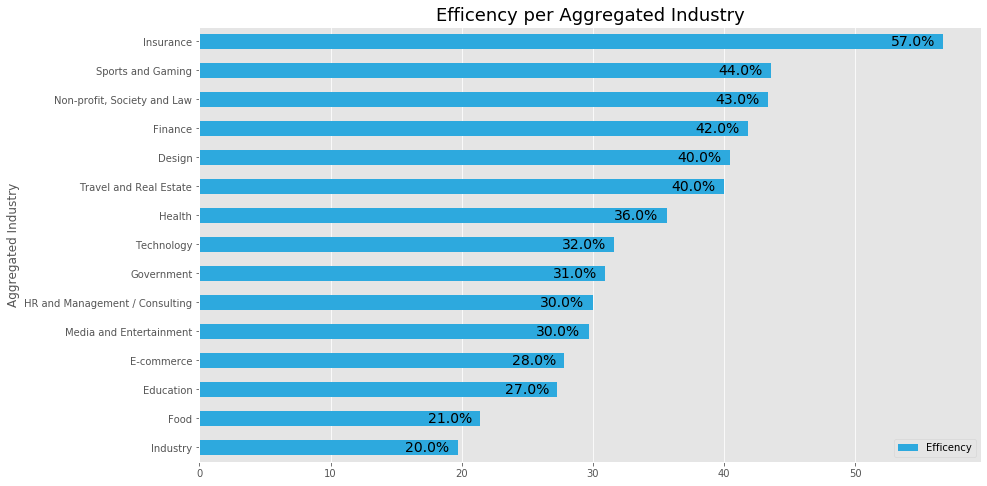

In [27]:
plot_efficency_for_comparison(industry_comparison, column_name)

# Additionally, lets rebuild the same charts for deal sources

In [28]:
column_name = 'Source'
number_of_deals_with_sources = deals_df[column_name].count()
print(number_of_deals_with_sources)

400


In [29]:
source_comparison = prepare_column_comparison(completed_with_found_companies, lost_with_found_companies, column_name)

source_comparison[column_name] = source_comparison[column_name].replace('None', np.nan)
source_comparison[column_name] = source_comparison[column_name].replace('', np.nan)
source_comparison = source_comparison[~source_comparison[column_name].isnull()]

source_comparison.head(20)

,Source,Closed deals,Lost deals
1,Upsell,30,27
2,Website,11,43
3,Referral,33,31
4,Cold Call,2,1
5,Expansion,17,5
6,Extension,11,4
7,Trade Show,1,4
8,Employee Referral,22,30
9,Existing client referral,69,52


In [30]:
source_comparison.to_csv("../data/tmp-source-comparison.csv")

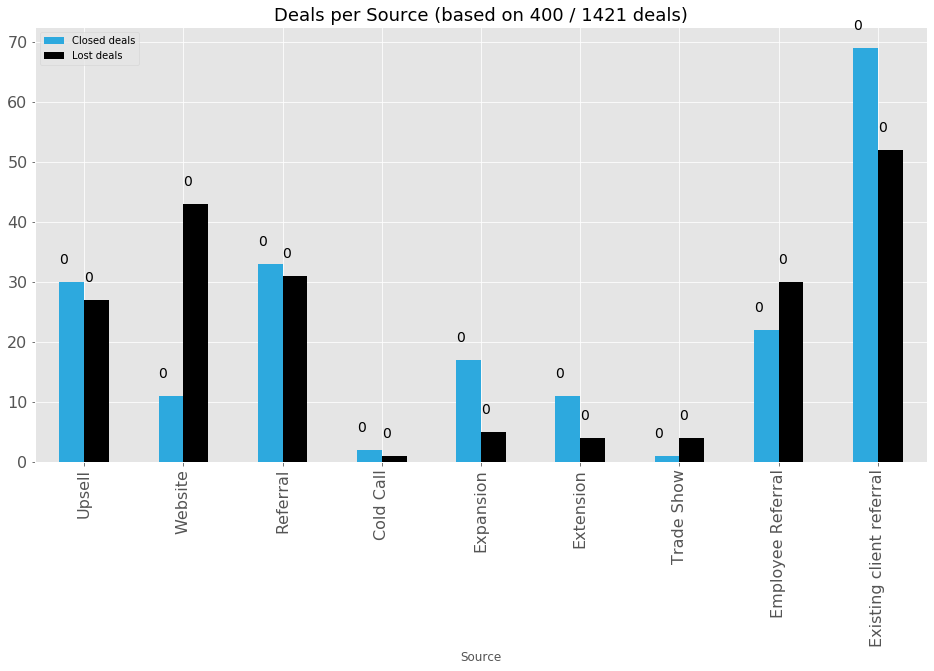

In [31]:
graph = source_comparison.plot(x=column_name, kind='bar', figsize=(16,8), fontsize=16, color=['#2da9de', 'black'])
graph.set_title("Deals per "+column_name+" (based on "+str(number_of_deals_with_sources)+" / 1421 deals)", fontsize=18)

for i in graph.patches:
    graph.text(i.get_x(), i.get_height() + 3, show_comparison_value(i), fontsize=14)

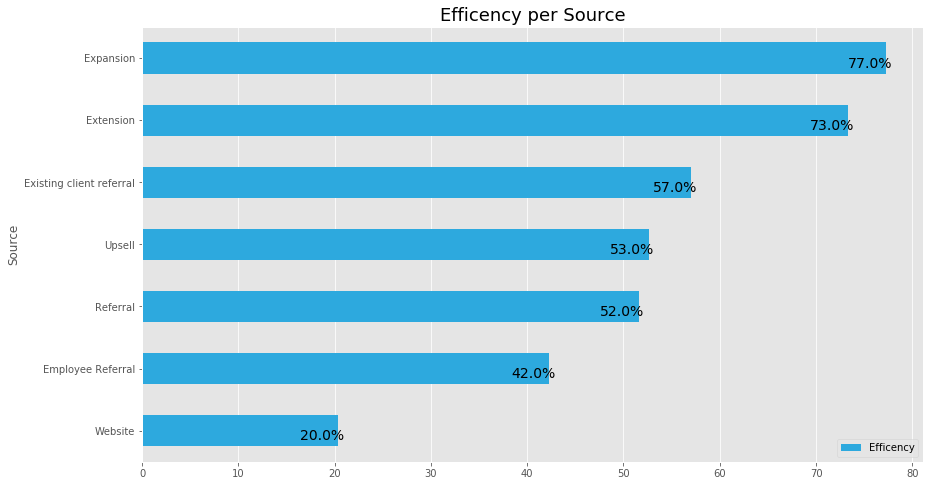

In [32]:
plot_efficency_for_comparison(source_comparison, column_name)

# Saving deals with mined company data

In [33]:
#completed_with_found_companies.to_csv('../data/closed-deals-with-mined-companies-data.csv', index=True)

In [34]:
#lost_with_found_companies.to_csv('../data/lost-deals-with-mined-companies-data.csv', index=True)

In [35]:
def show_closed_deals(closed_deals):
    if (closed_deals < 23):
        return str(closed_deals)
    return str(closed_deals) + " deals closed"

def show_row_summary(total, efficency):
    if (total > 19):
        return str(total)+" deals ("+str(round(efficency, 1))+"% closed)"
    return str(total)+" deals"

def plot_comparison(industry_comparison, column_name, number_of_companies):
    df = industry_comparison.copy()
    df['Total deals'] = df['Closed deals'] + df['Lost deals']
    df['Efficency'] = df['Closed deals'] / (df['Closed deals'] + df['Lost deals']) * 100
    df = df.sort_values(by=['Efficency'], ascending=True).reset_index()

    style.use('ggplot')

    dark_grey_color = '#29323C'

    graph = df.plot(x=column_name, y=['Closed deals', 'Lost deals'], kind='barh', stacked=True, figsize=(26,20), fontsize=16, color=['#27A8E0', '#626E7A'], legend=False)

    graph.set_title("Deals per "+column_name+" (based on "+str(number_of_companies)+"  / 1421 deals)", fontsize=22, color=dark_grey_color, pad=50)

    graph.patch.set_color('#EEF2F5')

    graph.tick_params(colors=dark_grey_color)

    graph.set_xlabel("Number of deals", fontsize=16, color=dark_grey_color)
    graph.set_ylabel(None)
    graph.xaxis.grid(True)
    graph.yaxis.grid(False)

    graph.set_xticks([25,50,75,100,125,150])

    height = 1
    for idx, row in df.iterrows():
        total = df.at[idx, 'Total deals']
        efficency = df.at[idx, 'Efficency']
        lost_deals = df.at[idx, 'Lost deals']
        closed_deals = df.at[idx, 'Closed deals']
        y = idx * height - 0.08
        graph.text(total + 1, y, show_row_summary(total, efficency), fontsize=14, color=dark_grey_color)
        graph.text(closed_deals + .1, y, str(lost_deals), fontsize=14, color=dark_grey_color)
        graph.text(.1, y, show_closed_deals(closed_deals), fontsize=14, color=dark_grey_color)

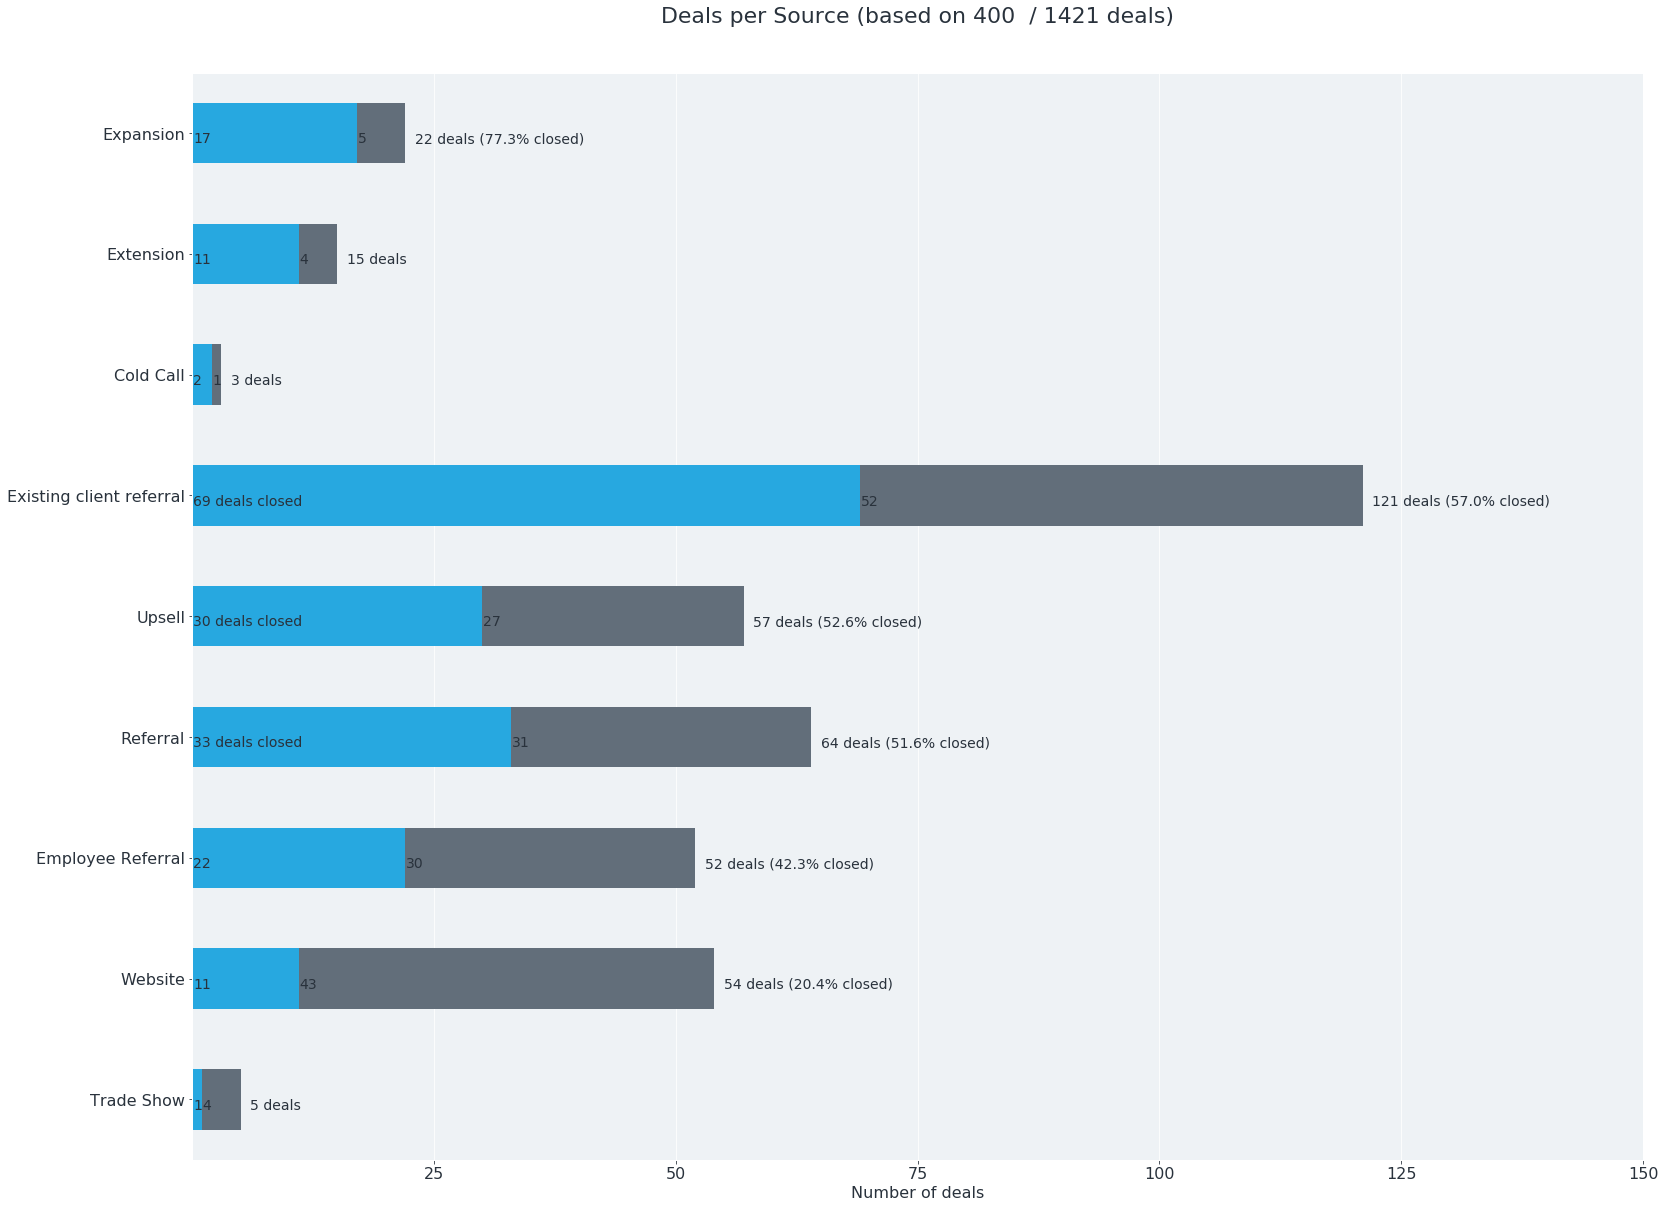

In [36]:
plot_comparison(source_comparison, 'Source', number_of_deals_with_sources)